In [1]:
!date

Wed Jan 20 20:14:44 PST 2021


# Memory and time

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import matplotlib
import json
import os

matplotlib.rcParams.update({'font.size': 20})

%config InlineBackend.figure_format = 'retina'

In [2]:
REF = {
    "arabidopsis-SRR8257100_v2": "arabidopsis-tair10",
    "fly-SRR8513910_v2": "fly-dm6",
    "human_mouse-hgmm1k_v2": "human_mouse-hg19_mm10",
    "human-SRR8327928_v2": "human-grch38",
    "human-SRR8524760_v2": "human-grch38",
    "mouse-EMTAB7320_v2": "mouse-mm10",
    "mouse-heart1k_v2": "mouse-mm10",
    "mouse-SRR6998058_v2": "mouse-mm10",
    "mouse-SRR8206317_v2": "mouse-mm10",
    "mouse-SRR8599150_v2": "mouse-mm10",
    "mouse-SRR8639063_v2": "mouse-mm10",
    "rat-SRR7299563_v2": "rat-rnor6",
    "worm-SRR8611943_v2": "worm-ws260",
    "zebrafish-SRR6956073_v2": "zebrafish-dr82",
    "human_mouse-hgmm10k_v3": "human_mouse-hg19_mm10",
    "human_mouse-hgmm1k_v3": "human_mouse-hg19_mm10", # redo
    "human-pbmc10k_v3": "human-grch38",
    "human-pbmc1k_v3": "human-grch38",
    "mouse-heart1k_v3": "mouse-mm10",
    "mouse-neuron10k_v3": "mouse-mm10",
}

In [3]:
def get_time(line):
    # returns milliseconds
    t = ":".join(line.split(":")[4:]).strip()
    hours, minutes, seconds = (["0", "0"] + t.split(":"))[-3:]
    hours = int(hours)
    minutes = int(minutes)
    seconds = float(seconds)
    ms = int(3600000 * hours + 60000 * minutes + 1000 * seconds)

    return ms
        
def get_mem(line):
    # returns bytes
    mem = int(line.split(':')[-1].strip())*1000
    return mem

def get_memtime(f):
    with open(f, 'r') as file:
        for idx, line in enumerate(file):
            if idx == 4:
                time = get_time(line)
            if idx == 9:
                mem = get_mem(line)
    return (mem, time)

### load kallisto index time and mem

In [4]:
# kb files
d = {}

d["index"] = {"time": [], "mem": []}
files = sorted(glob.glob(f'../../reference/*/index.log'))

mem = []
time = []
for f in files:
    m, t = get_memtime(f)
    mem.append(m)
    time.append(t)
d["index"]['time'] = time
d["index"]['mem'] = mem

In [5]:
names = [f.split("/")[-2] for f in files]

kb_idx = pd.DataFrame.from_dict({(i,j): d[i][j] 
                           for i in d.keys() 
                           for j in d[i].keys()})
kb_idx.index = names

### load alevin index time and mem

In [6]:
# al files
d = {}

d["index"] = {"time": [], "mem": []}
files = sorted(glob.glob(f'../../reference/*/salmon/index.log'))

mem = []
time = []
for f in files:
    m, t = get_memtime(f)
    mem.append(m)
    time.append(t)
d["index"]['time'] = time
d["index"]['mem'] = mem

In [7]:
names = [f.split("/")[-3] for f in files]

al_idx = pd.DataFrame.from_dict({(i,j): d[i][j] 
                           for i in d.keys() 
                           for j in d[i].keys()})
al_idx.index = names

### nreads

In [8]:
run_log = sorted(glob.glob('../../data/kallisto_out/*/run_info.json'))

In [9]:
nreads = []
for r in run_log:
    with open(r, 'r') as f:
        nreads.append(json.load(f)["n_processed"])

### load kallisto time and mem

In [10]:
steps = ['pseudoalignment', 'correct', "whitelist", 'sort', 'count', 'text'] # add bustools text

In [11]:
# kb files
d = {}
for step in steps:
    d[step] = {"time": [], "mem": []}
    files = sorted(glob.glob(f'../../data/kallisto_out/*/{step}.log'))

    mem = []
    time = []
    for f in files:
        m, t = get_memtime(f)
        mem.append(m)
        time.append(t)
    d[step]['time'] = time
    d[step]['mem'] = mem

In [12]:
names = [f.split("/")[4] for f in files]

kb = pd.DataFrame.from_dict({(i,j): d[i][j] 
                           for i in d.keys() 
                           for j in d[i].keys()})

files = sorted(glob.glob(f'../../data/kallisto_out/*/sc.bus'))
fsize = [os.path.getsize(f) for f in files]

kb.index = names
kb['nreads'] = nreads
kb['fsize', 'mem'] = fsize

In [13]:
kb['index', 'name'] = kb.index.map(REF)
kb['index', 'time'] = kb['index', 'name'].map(kb_idx['index', 'time'])
kb['index', 'mem'] = kb['index', 'name'].map(kb_idx['index', 'mem'])

### load alevin time and mem

In [14]:
# alevin files
d = {}
for step in steps:
    d[step] = {"time": [], "mem": []}
    files = sorted(glob.glob(f'../../data/alevin_out/*/{step}.log'))

    mem = []
    time = []
    for f in files:
        m, t = get_memtime(f)
        mem.append(m)
        time.append(t)
    d[step]['time'] = time
    d[step]['mem'] = mem

In [15]:
names = [f.split("/")[4] for f in files]

al = pd.DataFrame.from_dict({(i,j): d[i][j] 
                           for i in d.keys() 
                           for j in d[i].keys()})
al.index = names

files = sorted(glob.glob('../../data/alevin_out/*/generate/map.collated.rad'))

fsize = [os.path.getsize(f) for f in files]

al['nreads'] = nreads
al['fsize', 'mem'] = fsize

In [16]:
al['index', 'name'] = al.index.map(REF)
al['index', 'time'] = al['index', 'name'].map(al_idx['index', 'time'])
al['index', 'mem']  = al['index', 'name'].map(al_idx['index', 'mem'])

### sum time and take max of mem

In [17]:
CMDS = {
    'index': {
        "kb": "$ kallisto index",
        'al': "$ salmon index",
        'en': "Purpose: Build mapping index",
    }, 
    'pseudoalignment': {
        "kb": "$ kallisto bus",
        'al': "$ salmon alevin --rad",
        'en': "Purpose: Perform mapping",
    },  'fsize': {
        "kb": "BUS file",
        'al': "RAD file",
        'en': "Purpose: Store result of mapping",
    },  'correct': {
        "kb": "$ bustools correct",
        'al': "$ alevin-fry generate-permit-list",
        'en': "Purpose: Error correct of barcodes",
    },  'whitelist': {
        "kb": "$ bustools whitelist",
        'al': "$ alevin-fry generate-permit-list\n             --knee-distance",
        'en': "Purpose: Select high quality cells",
    },  'sort': {
        "kb": "$ bustools sort",
        'al': "$ alevin-fry collate",
        'en': "Purpose: Enable streaming",
    },  'count': {
        "kb": "$ bustools count",
        'al': "$ alevin-fry quant",
        'en': "Purpose: Generate count matrix",
    }, 'text': {
        'kb': '$ bustools text',
        'al': '$ alevin-fry view --rad',
        'en': 'Purpose: Convert binary to text'
    }
}

plot_steps = list(CMDS.keys())

plot_steps
time_steps = plot_steps.copy()
mem_steps  = plot_steps.copy()

time_steps.remove('fsize')
time_steps.remove('index')

mem_steps.remove('index')
mem_steps.remove('fsize')

In [18]:
plot_steps

['index',
 'pseudoalignment',
 'fsize',
 'correct',
 'whitelist',
 'sort',
 'count',
 'text']

In [19]:
kb['sum', 'time'] = np.sum([kb[step]['time'] for step in time_steps], axis=0)
kb['max', 'mem']  = kb[[(step, 'mem') for step in mem_steps]].max(axis=1)

al['sum', 'time'] = np.sum([al[step]['time'] for step in time_steps], axis=0)
al['max', 'mem']  = al[[(step, 'mem') for step in mem_steps]].max(axis=1)

# Plot

In [20]:
kallisto_color = '#377eb8'
alevin_color = "#e41a1c"
alpha = 0.2

In [21]:
def plot_time(step, kb, al, ax, label_top=False, label_bottom=True):
    measurement = "time"

    title = f"{step}"

    for nr in kb['nreads']:
        ax.axvline(x=nr,linewidth=1, color='lightgrey', linestyle='--', zorder=1)

    x = kb['nreads']
    y = kb[f'{step}'][f'{measurement}']/1000/60
    amin = min(y)

    ax.scatter(x,y, color=kallisto_color, label="kallisto")

    x = al['nreads']
    y = al[f'{step}'][f'{measurement}']/1000/60
    kmin = min(y)

    ax.scatter(x,y, color=alevin_color, zorder=-1, label= "alevin")

    if label_top:
        ax.set_title(f'{measurement}', fontweight='bold', loc = 'center' )
        ## add labels on top
        ax2 = ax.twiny()
        ax2.set(**{
            "xticks": np.linspace(kb['nreads'].min(), kb['nreads'].max(), kb.shape[0]),
            "xticklabels": kb.sort_values('nreads').index.values,
        })

        for label in ax2.get_xticklabels():
            label.set_rotation(-45)
            label.set_horizontalalignment("right")

        ax2.tick_params(
            axis='x',          # changes apply to the x-axis
            which='minor',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off

    kwd = {
        'xscale': "log",
        "ylabel": f"Time [min]",
        'xlabel': "",
        'xticklabels': [],
    } 
    if label_bottom:
        kwd.update({
            'xlabel': "Number of reads",
        })
        kwd.pop('xticklabels')

    ax.set(**kwd)

    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = alpha)

    ax.legend(markerscale=2)
    return ax

In [22]:
def plot_mem(step, kb, al, ax, label_top=False, label_bottom=True):
    measurement = "mem"

    title = f"{step}"

    for nr in kb['nreads']:
        ax.axvline(x=nr,linewidth=1, color='lightgrey', linestyle='--', zorder=1)

    x = kb['nreads']
    y = kb[f'{step}'][f'{measurement}']/10**9
    ax.scatter(x,y, color=kallisto_color, label="kallisto")

    x = al['nreads']
    y = al[f'{step}'][f'{measurement}']/10**9
    ax.scatter(x,y, color=alevin_color, zorder=-1, label= "alevin")


    if label_top:
        ax.set_title(f'{measurement}'+'ory', fontweight='bold', loc = 'center' )
        ## add labels on top
        ax2 = ax.twiny()
        ax2.set(**{
            "xticks": np.linspace(kb['nreads'].min(), kb['nreads'].max(), kb.shape[0]),
            "xticklabels": kb.sort_values('nreads').index.values,
        })

        for label in ax2.get_xticklabels():
            label.set_rotation(-45)
            label.set_horizontalalignment("right")

        ax2.tick_params(
            axis='x',          # changes apply to the x-axis
            which='minor',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    ylabel = "Memory [Gb]"
    if step=='fsize': ylabel="Size [Gb]"
    kwd = {
        'xscale': "log",
        "ylabel": ylabel,
        "xlabel": "",
        'xticklabels': [],
        'ylim': min(ax.get_ylim()[0], 0)
    }
    if label_bottom:
        kwd.update({
            'xlabel': "Number of reads",
        })
        kwd.pop("xticklabels")
        
    ax.set(**kwd)

    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = alpha)

    ax.legend(markerscale=2)
    return ax

In [23]:
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

In [24]:
colors = [kallisto_color, alevin_color, "black"]

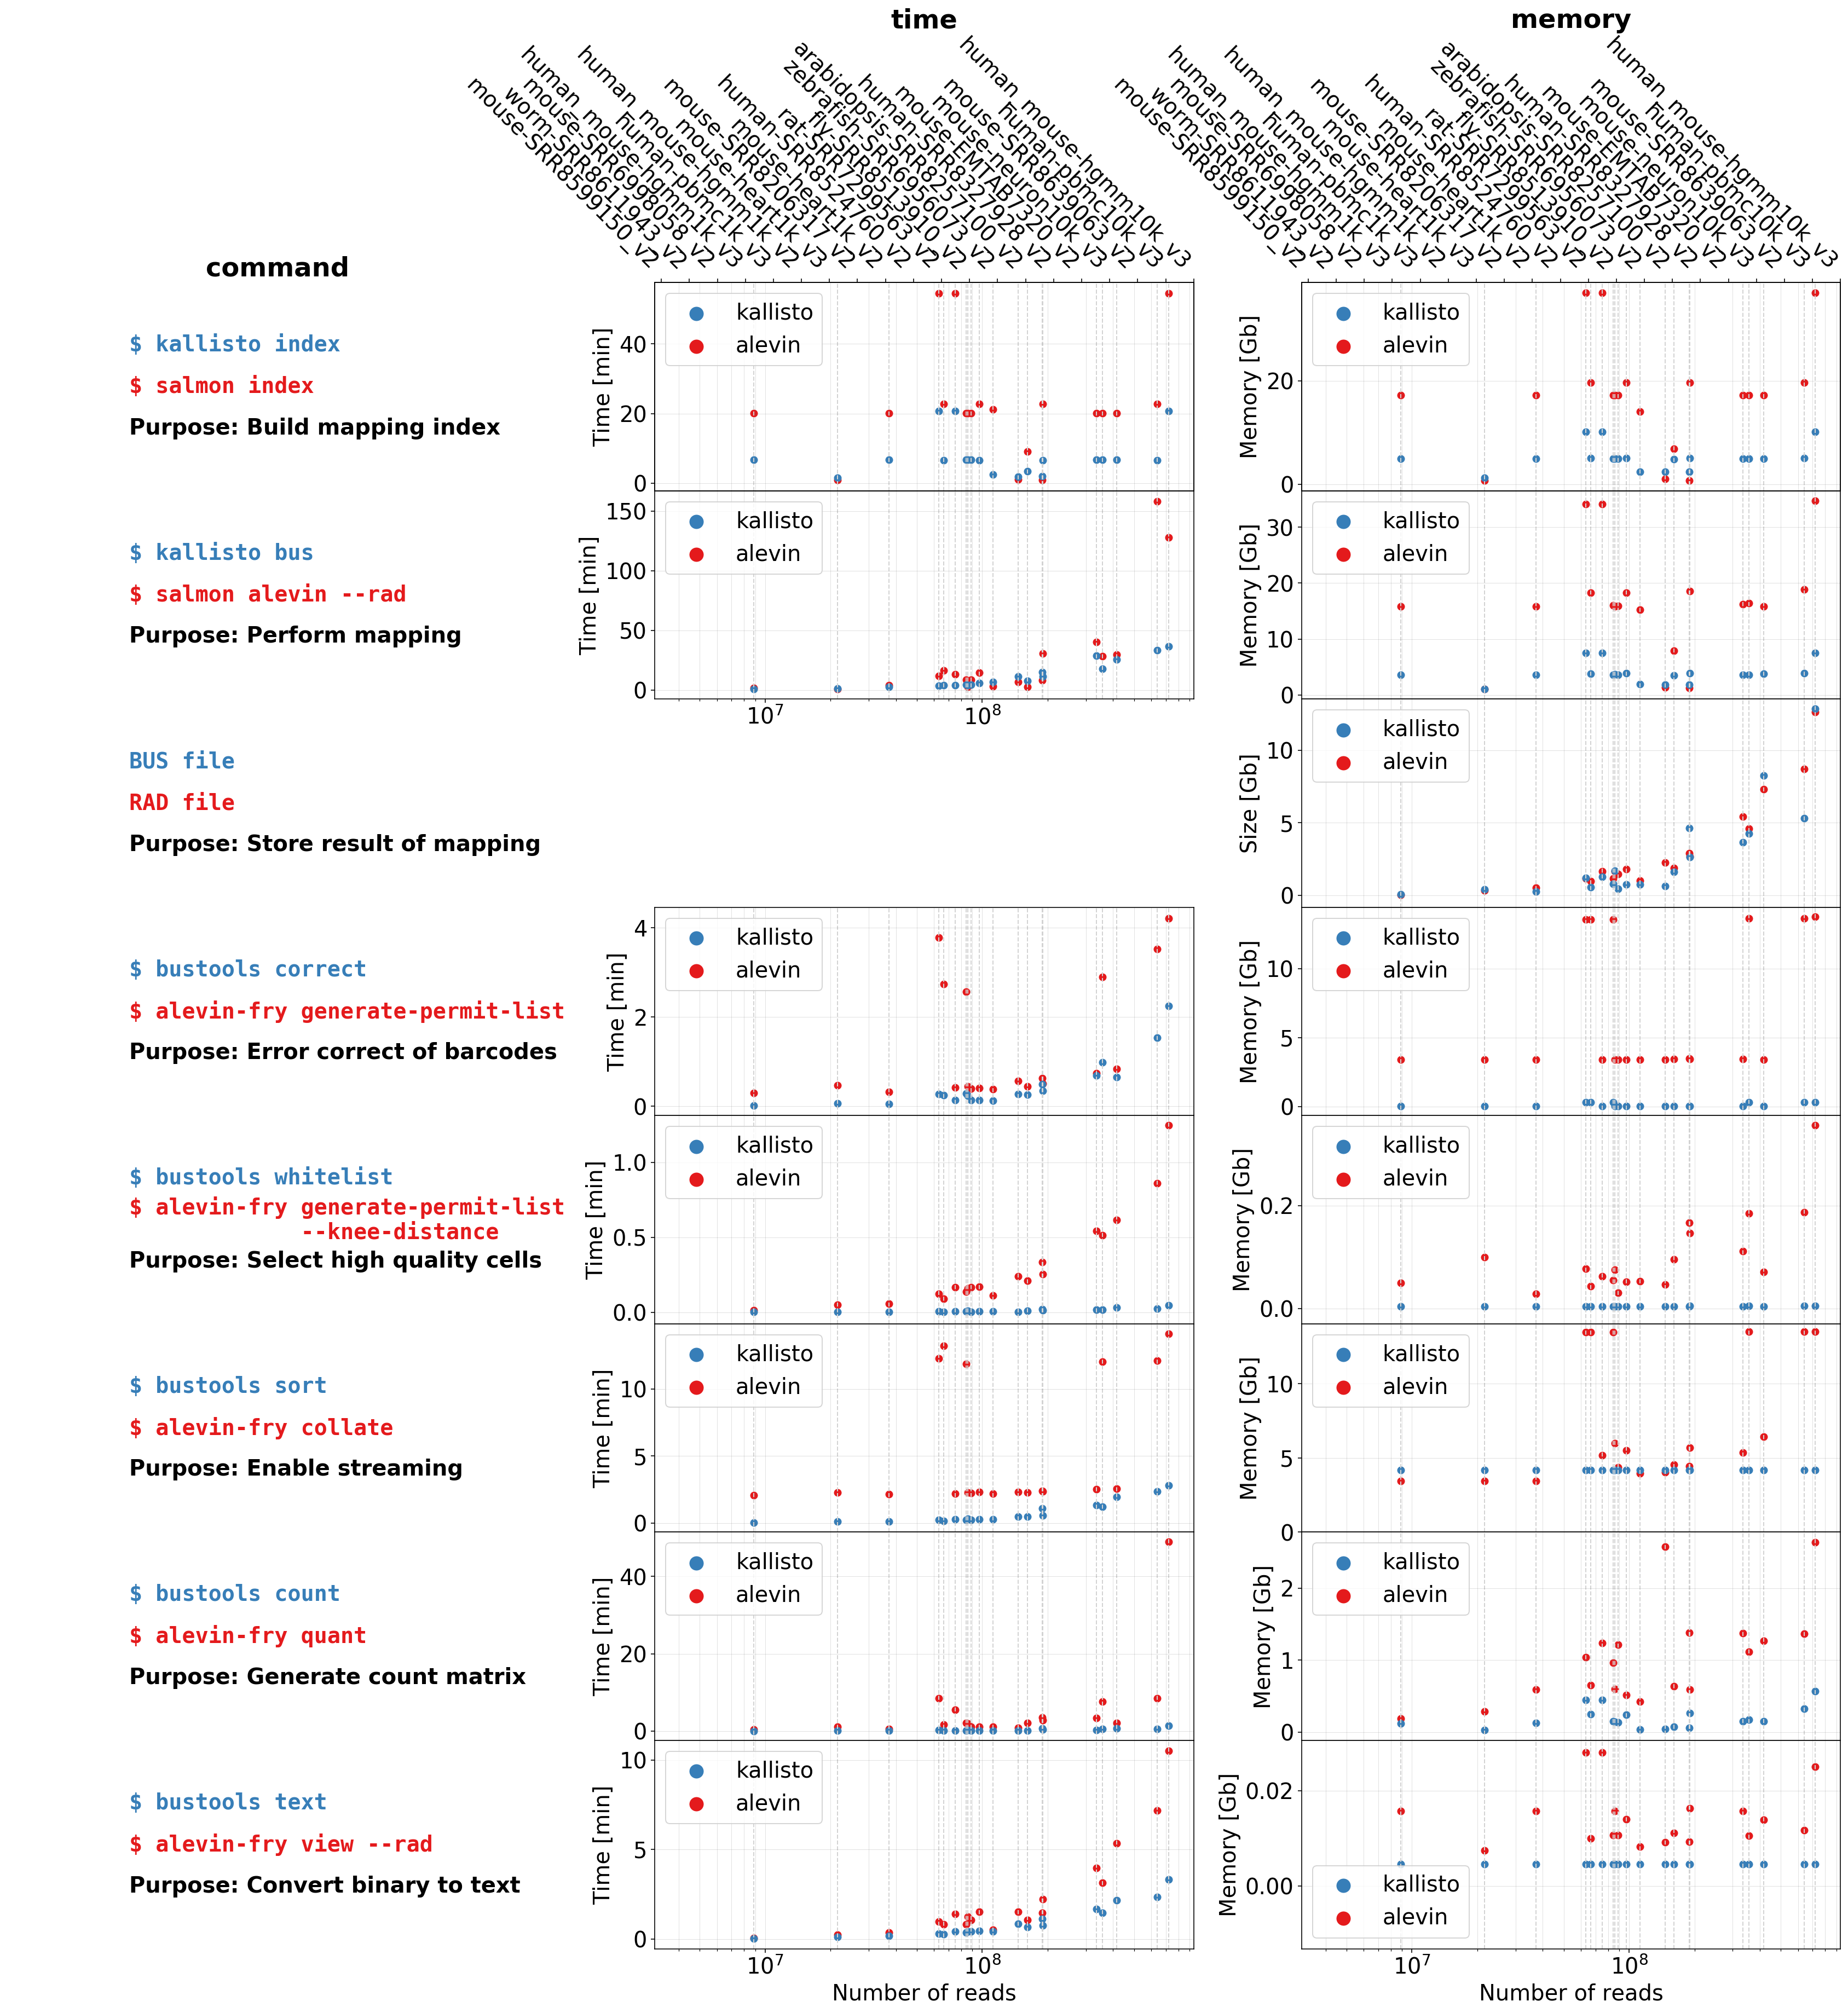

In [25]:
n = len(plot_steps)
fig = plt.figure(figsize=(15*2, n*3.5))

gs = fig.add_gridspec(n, 3, hspace=0.0)

axs = [
    (fig.add_subplot(gs[i, 0]), fig.add_subplot(gs[i, 1]), fig.add_subplot(gs[i, 2])) for i in range(len(plot_steps))
]

for idx, ((cmd_ax, time_ax, mem_ax), step) in enumerate(zip(axs, plot_steps)):
    label_top=False
    label_bottom=False
    if idx == 0: label_top=True; cmd_ax.set_title('command', fontweight='bold', loc = 'center' );
    if idx == n-1: label_bottom=True;
    
    # add commands to first column    
    cmds = list(CMDS[step].values())
    ncmds = len(cmds)
    for cidx, (c, color) in enumerate(zip(cmds, colors), -1):
        fontfamily = "monospace"
        if cidx==1: fontfamily = "sans"; 
        kwd = {
                "horizontalalignment": "left",
                "verticalalignment": "center",
                "fontfamily": fontfamily,
                "fontweight":  "bold",
                "fontsize": 20,
                "color": color,
                "transform": cmd_ax.transAxes
        }
        x = 0.225
        y = 0.5*(bottom+top)-cidx/(len(cmds)+2)
        cmd_ax.text(x,y,c, **kwd)
    cmd_ax.set_axis_off()
    
    if step == 'fsize':
        plot_mem(step, kb, al, mem_ax, label_top=label_top, label_bottom=label_bottom)
        time_ax.set_axis_off()
    else:
        plot_time(step, kb, al, time_ax, label_top=label_top, label_bottom=label_bottom)
        plot_mem(step, kb, al, mem_ax, label_top=label_top, label_bottom=label_bottom)

fig.savefig('memtime.png', dpi=300, bbox_inches='tight')
fig.show()

In [26]:
kb['pseudoalignment']['mem']/10**9

arabidopsis-SRR8257100_v2    1.840536
fly-SRR8513910_v2            1.786536
human-SRR8327928_v2          3.861884
human-SRR8524760_v2          3.858280
human-pbmc10k_v3             3.840380
human-pbmc1k_v3              3.784628
human_mouse-hgmm10k_v3       7.549540
human_mouse-hgmm1k_v2        7.483212
human_mouse-hgmm1k_v3        7.473612
mouse-EMTAB7320_v2           3.634764
mouse-SRR6998058_v2          3.609084
mouse-SRR8206317_v2          3.676224
mouse-SRR8599150_v2          3.595784
mouse-SRR8639063_v2          3.803028
mouse-heart1k_v2             3.598520
mouse-heart1k_v3             3.597888
mouse-neuron10k_v3           3.603832
rat-SRR7299563_v2            1.884868
worm-SRR8611943_v2           1.047956
zebrafish-SRR6956073_v2      3.519448
Name: mem, dtype: float64

# Sum time and max mem

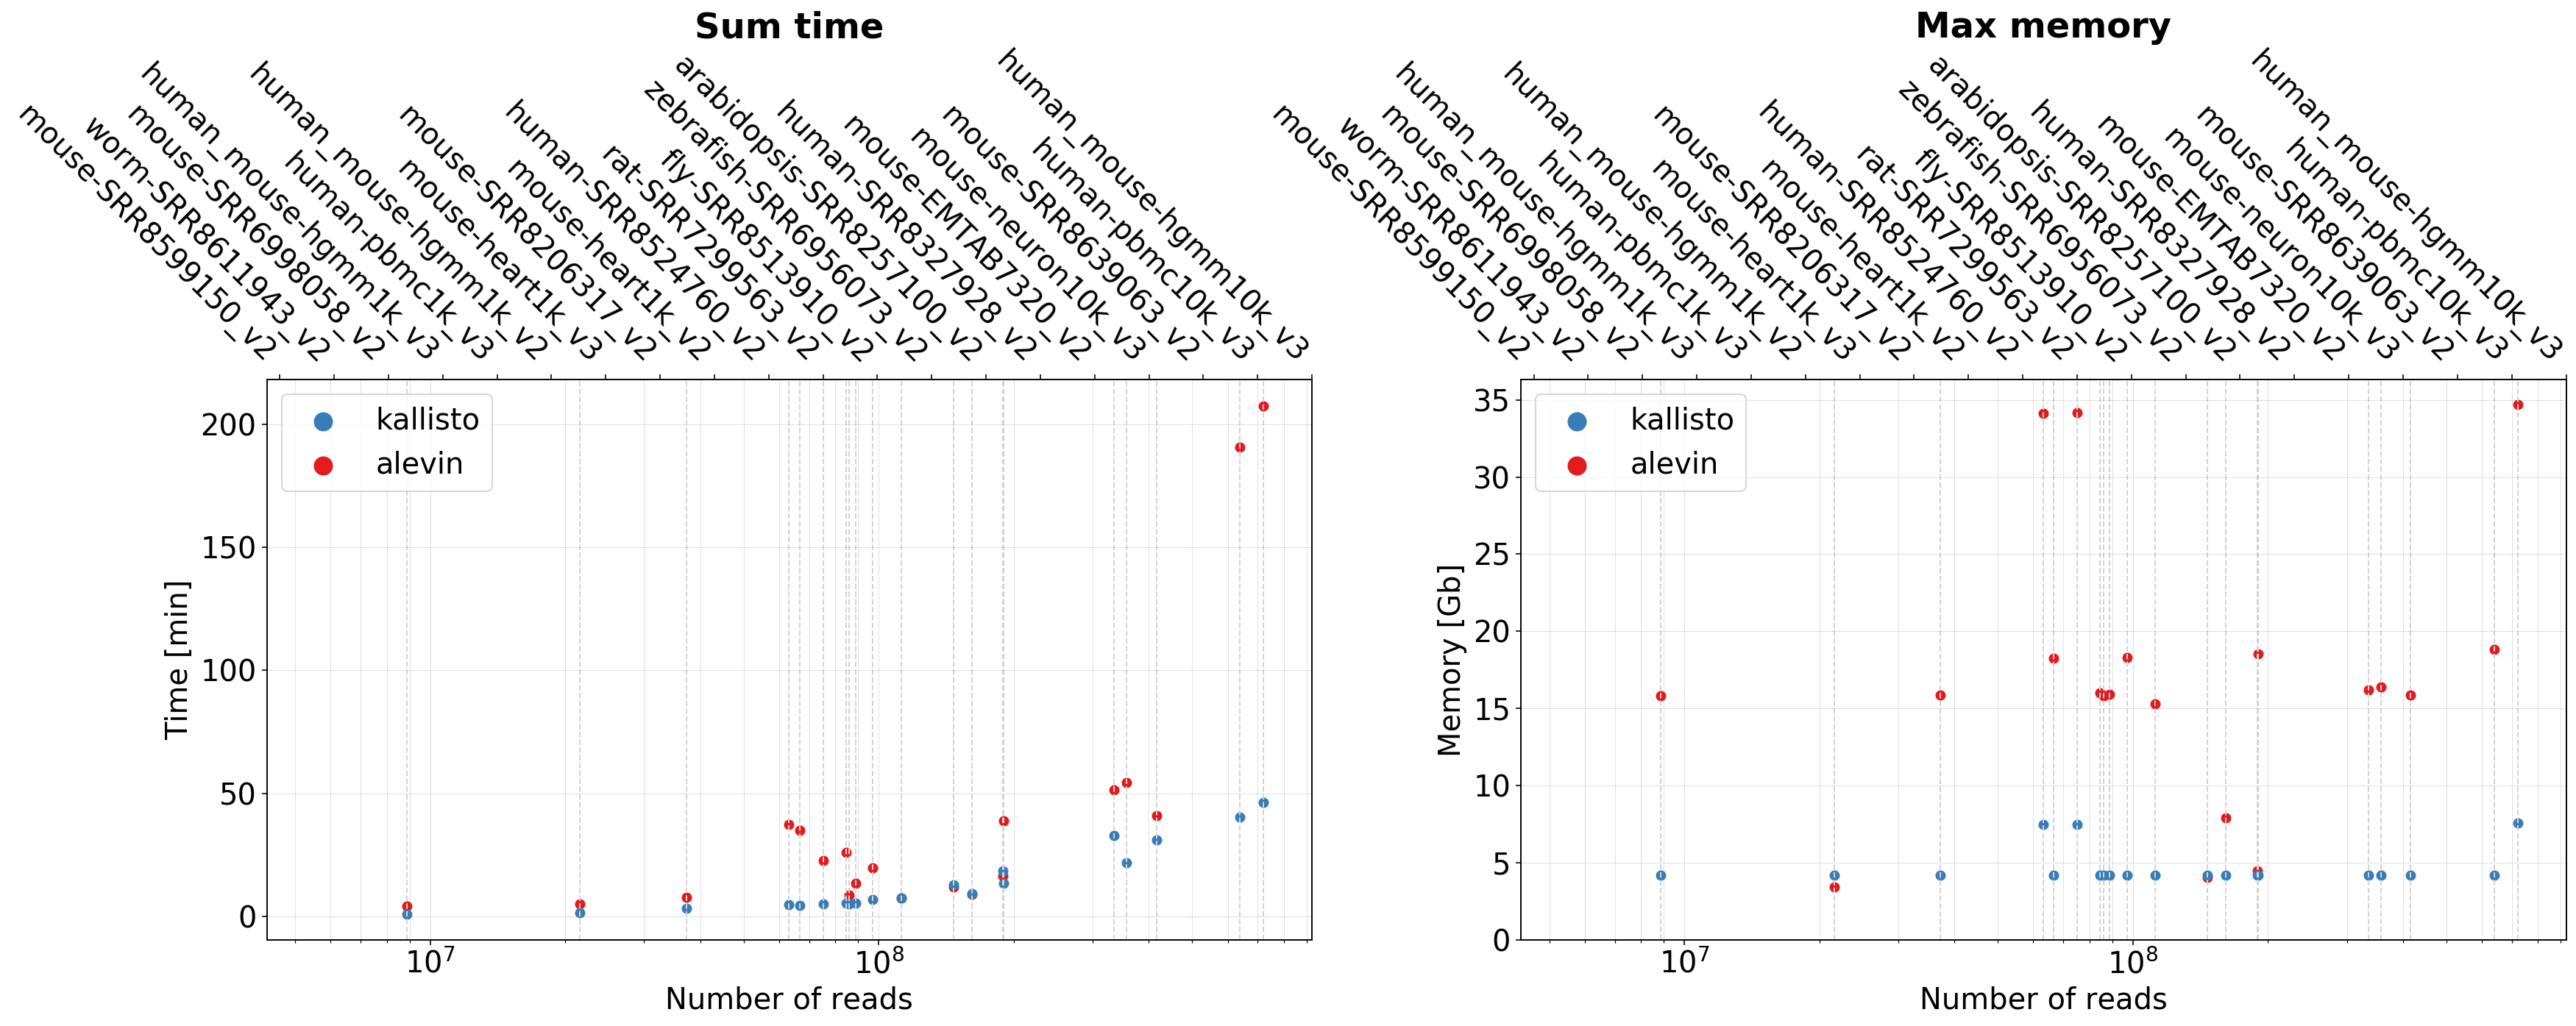

In [27]:
fig, ax = plt.subplots(figsize=(14*2, 7), ncols=2)

# sum
plot_time('sum', kb, al, ax[0], label_top=True, label_bottom=True)
ax[0].set_title('Sum time', fontweight='bold')
plot_mem('max', kb, al, ax[1], label_top=True, label_bottom=True)
ax[1].set_title('Max memory', fontweight='bold')

fig.savefig('sum_max_memtime.png', dpi=300, bbox_inches='tight')

fig.show()

In [28]:
print('kallisto')
kb_time = kb.loc['human-pbmc10k_v3']['sum']['time']/1000/60
kb_mem = kb.loc['human-pbmc10k_v3']['max']['mem']/10**9
print(f"{kb_time} min")
print(f"{kb_mem} Gb")

kallisto
40.329166666666666 min
4.1958 Gb


In [29]:
print('alevin')

al_time = al.loc['human-pbmc10k_v3']['sum']['time']/1000/60
al_mem = al.loc['human-pbmc10k_v3']['max']['mem']/10**9

print(f"{al_time} min")
print(f"{al_mem} Gb")

alevin
190.74066666666667 min
18.828952 Gb


https://aws.amazon.com/ec2/pricing/on-demand/

In [30]:
cost_4  = 0.077
cost_32 = 0.616

In [31]:
kb_cost = kb_time /60 * cost_4
al_cost = al_time /60 * cost_32

In [32]:
kbc = float(f'{kb_cost:,.2f}')
alc = float(f'{al_cost:,.2f}')

print(f'kallisto costs ${kbc}')
print(f'  alevin costs ${alc}')
print(f'alevin is {alc/kbc:,.0f} times more expensive than kallisto')

kallisto costs $0.05
  alevin costs $1.96
alevin is 39 times more expensive than kallisto


In [33]:
# not in human mouse
max(al[~al.index.str.contains('hgmm')]['max']['mem'])/10**9

18.828952

In [34]:
# human mouse
al.loc['human_mouse-hgmm10k_v3']['max']['mem']/10**9

34.706564

In [35]:
kb.loc['human_mouse-hgmm10k_v3']['max']['mem']/10**9

7.54954

In [36]:
kb_mean_time = kb['sum']['time'].mean()/1000/60
al_mean_time = al['sum']['time'].mean()/1000/60

In [37]:
print(f"average kb time: {kb_mean_time:,.2f} min")
print(f"average al time: {al_mean_time:,.2f} min")
print(f"alevin is {al_mean_time/kb_mean_time:,.0f} times slower than kallisto")

average kb time: 13.89 min
average al time: 40.47 min
alevin is 3 times slower than kallisto
